# Automatic differentiation
Many algorithms require not only the function itself, but also the derivative to work.
For sufficiently complex functions, computing the derivative by hand can be quite tedious,
which is why one may want to use automatic differentiation libraries such as [Autograd](https://github.com/hips/autograd)
or its successor [JAX](https://github.com/google/jax). JAX offers more functionality than just differentation, such as
just-in-time compilation of functions to improve performance, but in this section we will focus on automatic differentiation using JAX (the API of Autograd should work roughly the same).

The basis for automatic differentiation is JAXs ```grad``` function. ```grad``` takes a function and returns that functions derivative. 

In [1]:
from jax import grad
def f(x):
    return x**5 + 30 * x**2 + 5
df = grad(f)

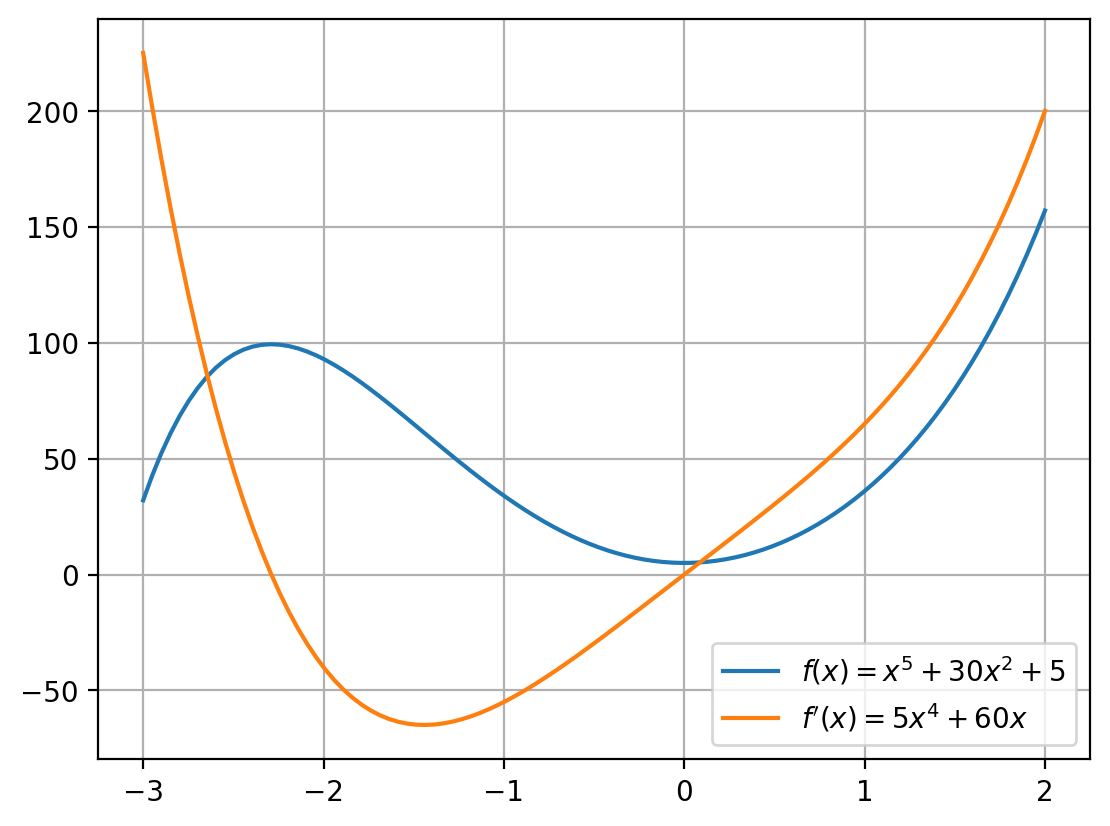

In [2]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
ax = np.linspace(-3, 2, 100)
fax = [f(x) for x in ax]
dfax = [df(x) for x in ax]
plt.plot(ax,fax, label="$f(x)=x^5+30x^2+5$")
plt.plot(ax,dfax, label="$f'(x)=5x^4+60x$")
plt.legend()
plt.grid()
plt.show()

```grad``` can also handle basic python control structures like loops or conditionals:

In [3]:
roots = [0.4, 3.8, -2]
def f(x):
    product = 1
    for r in roots:
        product *= x-r
    return product
df = grad(f)

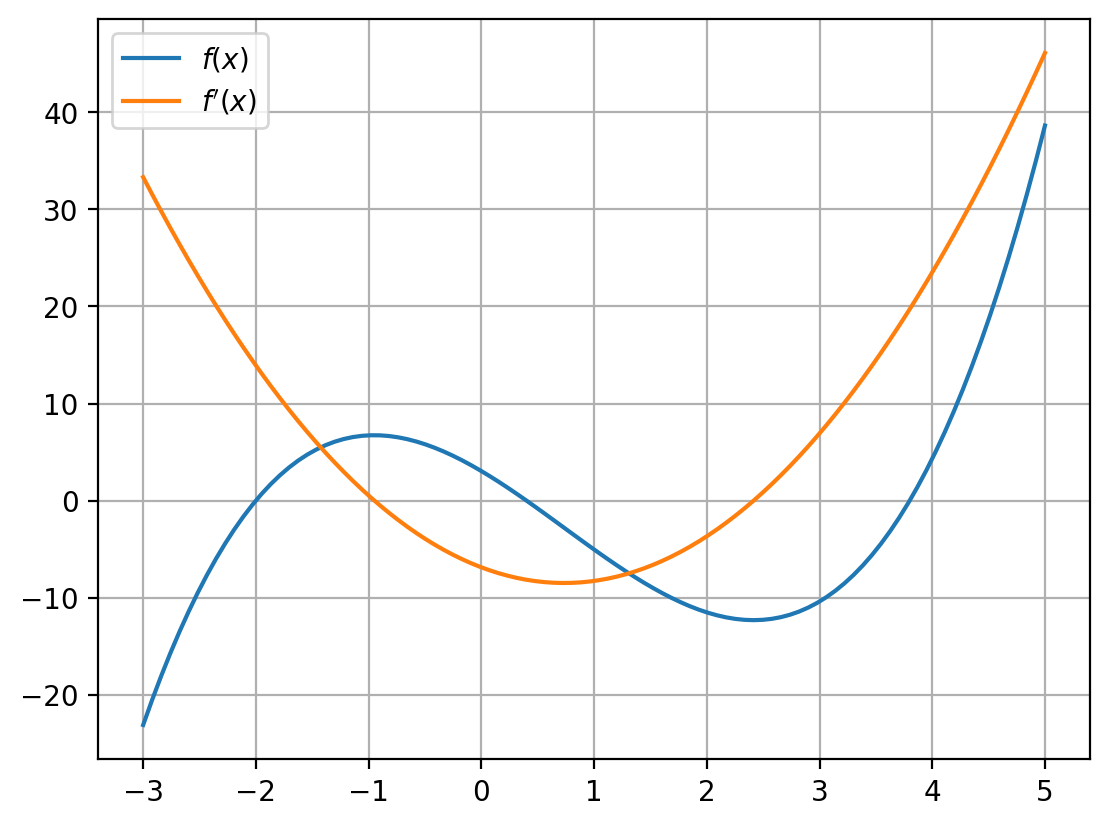

In [4]:
ax = np.linspace(-3, 5, 100)
fax = [f(x) for x in ax]
dfax = [df(x) for x in ax]
plt.plot(ax,fax, label="$f(x)$")
plt.plot(ax,dfax, label="$f'(x)$")
plt.legend()
plt.grid()
plt.show()

To use numpy functions, JAX exposes a wrapper to numpy:

In [5]:
import jax.numpy as jnp
def f(x):
    return jnp.sin(x)
df = grad(f)

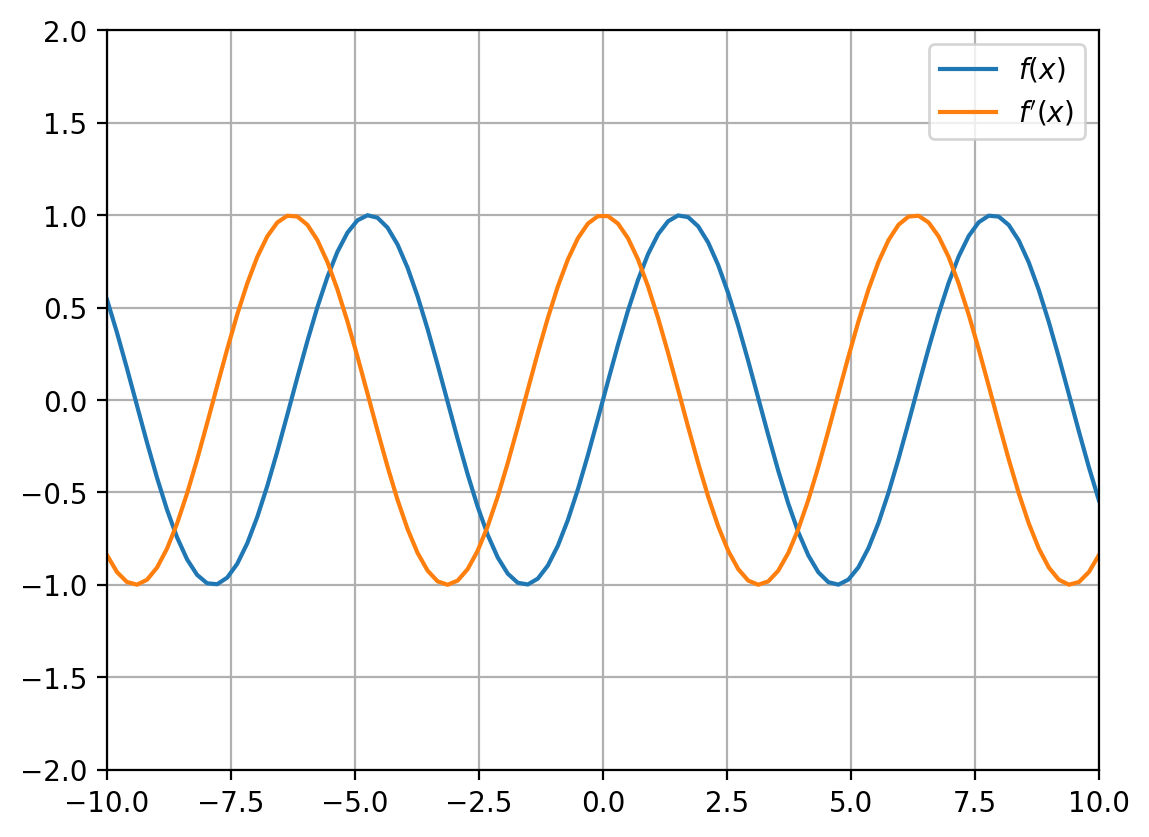

In [6]:
ax = np.linspace(-10, 10, 100)
fax = [f(x) for x in ax]
dfax = [df(x) for x in ax]
plt.plot(ax,fax, label="$f(x)$")
plt.plot(ax,dfax, label="$f'(x)$")
plt.legend()
plt.grid()
plt.ylim(-2,2)
plt.xlim(-10, 10)
plt.show()

Since ```grad``` returns a function, one can apply it to itself again to obtain higher-order derivatives:

In [7]:
d6f = grad(grad(grad(grad(grad(grad(f))))))

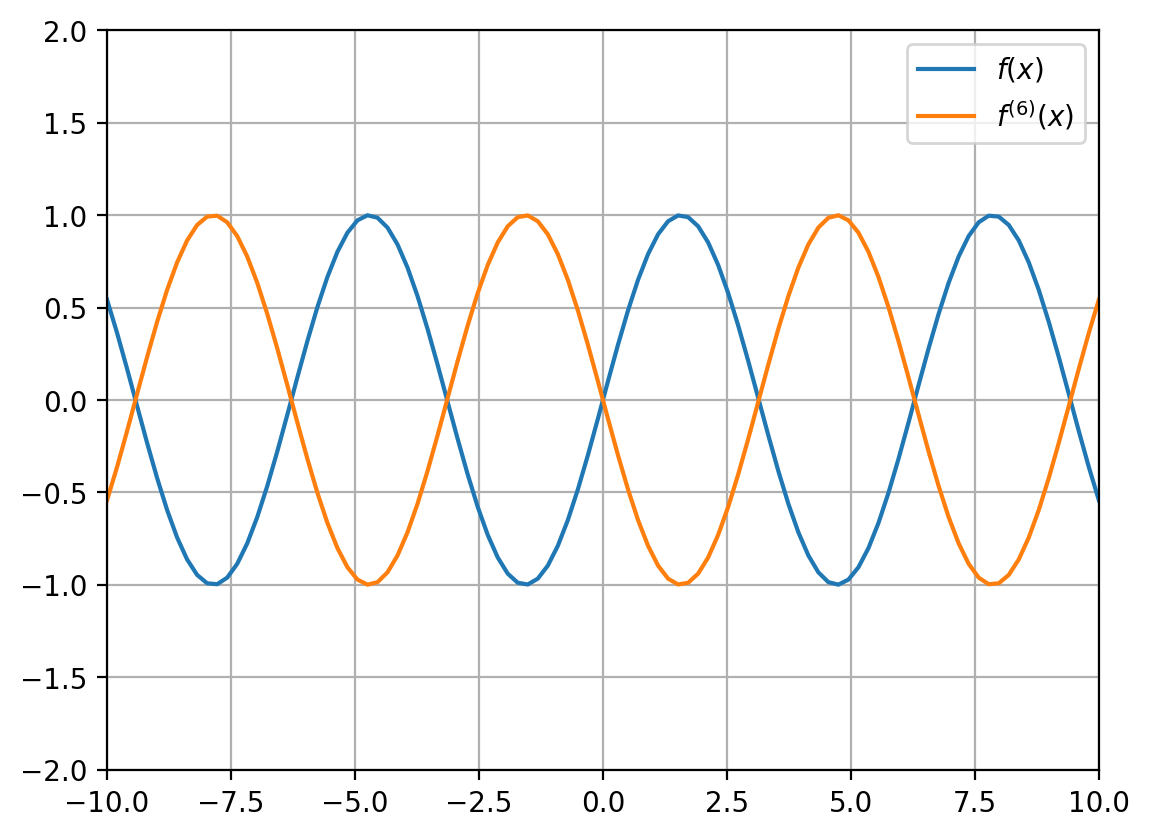

In [8]:
ax = np.linspace(-10, 10, 100)
fax = [f(x) for x in ax]
dfax = [df(x) for x in ax]
plt.plot(ax,fax, label="$f(x)$")
plt.plot(ax, [d6f(x) for x in ax], label="$f^{(6)}(x)$")
plt.legend()
plt.grid()
plt.ylim(-2,2)
plt.xlim(-10, 10)
plt.show()

## Caveats
When using JAX, one needs to be aware of its disadvantages and technicalities.

First off, if ```f``` returns a real or complex number, ```df=grad(f)```returns a ```DeviceArray```-type. To ensure
that this works with PyZEAL, ```df``` has to be wrapped:

In [9]:
def f(x):
    return x**5-1
_df = grad(f)
def df(x):
    return complex(_df(x))
print(type(_df(1.0)), type(df(1.0)))

<class 'jaxlib.xla_extension.DeviceArray'> <class 'complex'>


Further, ```grad``` has to be called with ```holomorphic=True``` to support differentiation at complex inputs.
A working example with the Newton-rootfinder would be:

In [10]:
from rootfinder.newton_grid import NewtonGridRootFinder
from jax import grad

def f(x):
    return x**5-1
_df = grad(f, holomorphic=True)
def df(x):
    return complex(_df(x))

gridRF = NewtonGridRootFinder(f, df)
gridRF.calcRoots((-2.0, 2.0), (-2.0, 2.0), (6, 6)) 
print("Roots: " + str(gridRF.getRoots()))

Roots: [-0.809017-0.587785j  0.309017-0.951057j  0.309017+0.951057j
 -0.809017+0.587785j  1.      +0.j      ]


If you run this example, you will notice a significant hit to performance. Used like this, JAXs automatic differentiation is drastically slower than direct evaluation, as can be seen in this comparison:

In [11]:
gridRF2 = NewtonGridRootFinder(f, df=lambda x: 5 * x**4)

%timeit gridRF.calcRoots((-2.0, 2.0), (-2.0, 2.0), (6, 6)) # using JAX
%timeit gridRF2.calcRoots((-2.0, 2.0), (-2.0, 2.0), (6, 6)) # normal

5.13 s ± 178 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
186 ms ± 754 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Thus, one should try to avoid automatic differentiation if runtime is of concern.